# Polarity prediction on movie reviews, comparaison of parameters and learning methods

## Importing libraries
(scikit-learn for learning, nltk for text processing and pandas for data reprensentations)

## Learning methods
To classify a vector of numbers, we used :

- Linear regression
- MultinomialNM
- 
- 

## Text representations
We tried different representations of data to see how it influences the learning :
- Bag-of-words
- n-grams
- Term frequency (bag-of-words normalized)
- Term frequency times inverse document frequency 

## Importing libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scikitplot.metrics import plot_confusion_matrix

## Importing the datasets
(We used the small dataset)

In [27]:
# Get all files path
posFiles = glob('review_polarity/txt_sentoken/pos/*')
negFiles = glob('review_polarity/txt_sentoken/neg/*')
# Read text files
posReviews = np.array([open(f).read() for f in posFiles])
negReviews = np.array([open(f).read() for f in negFiles])
# Use pandas to label, mix the data and print a sample
polarity_files_df = pd.DataFrame({'pos':posReviews,'neg':negReviews})
polarity_files_df = pd.melt(polarity_files_df, value_vars=['pos','neg'],value_name="text",var_name="label")
polarity_files_df["label_num"] = polarity_files_df.label.map({"neg":0, "pos":1})
polarity_files_df.sample(5)

,label,text,label_num
1355,neg,the summer of 00' wasn't a very good one for d...,0
1115,neg,"ever since wargames , the first real computer ...",0
672,pos,"three things i learned from "" being john malko...",1
1921,neg,a friend invites you to a movie . \nthis film ...,0
1950,neg,and just when you thought joblo was getting a ...,0


In [28]:
# Split and shuffle the data (15% for train and 75% for tests)

X_train, X_test, y_train, y_test = train_test_split(polarity_files_df.text, polarity_files_df.label_num, test_size=0.15, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1700,)
(300,)
(1700,)
(300,)


              precision    recall  f1-score   support

         pos       0.81      0.81      0.81       151
         neg       0.81      0.81      0.81       149

   micro avg       0.81      0.81      0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



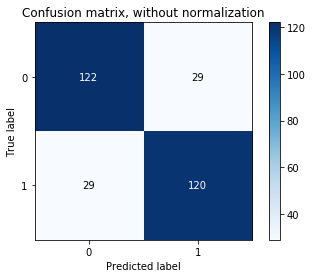

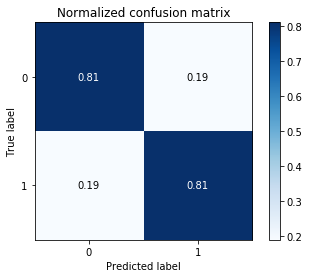

In [33]:
# Remove English stop words
# Include 1-grams and 2-grams (if 3-grams : seems not better because of the length of the vector)
# Ignore terms that appear in more than 60% of the documents
# (intuitively meaningful, at 60% of word frequency in english, we still find words like "uh" or a lot of words unnecessary for the learning) 
# Only keep terms that appear in at least 2 documents

# Note: Removing "stop-words" can lead in information loss
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range =(1,2), max_df =0.7, min_df=2)),
                     ('nb', MultinomialNB()),
                    ])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# à vérifier : pos et neg sont biens les pos et neg
print(metrics.classification_report(y_test, y_pred,
    target_names=["pos","neg"]))
metrics.accuracy_score(y_test, y_pred)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title='Normalized confusion matrix')

In [34]:
#test a range of hyperparameters
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range =(1,3), max_df =0.7, min_df=2)),
                     ('tfidf', TfidfTransformer()),
                     ('nb', MultinomialNB()),
                    ])

text_clf.fit(X_train, y_train)  
text_clf.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=0.7, max_features=None, min_df=2,
           ngram_range=(1, 3), preprocessor=None, stop_words='english',
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=None, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=0.7, max_features=None, min_df=2,
         ngram_range=(1, 3), preprocessor=None, stop_words='english',
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 

In [70]:
from sklearn.model_selection import GridSearchCV
#TO ADAPT depending on what text_clf.get_params() displays
#how did we look for a good parameter alpha : try with 1e-3 and 1e-2 : 1e-2 is the best so we tried with 1e0 and 1e-1 and 1e-2 : 1e-1 is the best one
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'nb__alpha': (1e-2, 1e-1),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, return_train_score=True)

In [71]:
gs_clf = gs_clf.fit(X_train, y_train)
y_pred = gs_clf.predict(X_test)

gs_clf.best_score_  

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.82835820895522383

In [69]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

nb__alpha: 0.1
tfidf__use_idf: False
vect__ngram_range: (1, 1)


In [62]:
gs_clf.best_estimator_

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...False,
         use_idf=False)), ('nb', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [63]:
gs_clf.best_estimator_.get_params()["nb"]

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [64]:
gs_clf.cv_results_

{'mean_fit_time': array([ 0.90705363,  2.97942503,  0.81350295,  3.52606408,  0.84179568,
         3.05628093,  0.86787113,  2.99055672,  0.8450772 ,  2.92341105,
         0.79071728,  2.67280912]),
 'mean_score_time': array([ 0.36827596,  0.56174795,  0.35869686,  0.54121161,  0.4139332 ,
         0.64748732,  0.40891202,  0.57405368,  0.3593332 ,  0.57712452,
         0.34732358,  0.47334862]),
 'mean_test_score': array([ 0.80074627,  0.79328358,  0.82835821,  0.82014925,  0.77835821,
         0.77537313,  0.80149254,  0.79626866,  0.76119403,  0.76343284,
         0.78283582,  0.77835821]),
 'mean_train_score': array([ 0.99291072,  0.9981353 ,  0.98656841,  0.99515037,  0.99776203,
         1.        ,  0.99253787,  0.99925429,  0.99925429,  1.        ,
         0.99776203,  1.        ]),
 'param_nb__alpha': masked_array(data = [0.1 0.1 0.1 0.1 0.01 0.01 0.01 0.01 0.001 0.001 0.001 0.001],
              mask = [False False False False False False False False False False False False]

In [65]:
import pandas as pd
df = pd.DataFrame(gs_clf.cv_results_)
print(df)

    mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0        0.907054         0.368276         0.800746          0.992911   
1        2.979425         0.561748         0.793284          0.998135   
2        0.813503         0.358697         0.828358          0.986568   
3        3.526064         0.541212         0.820149          0.995150   
4        0.841796         0.413933         0.778358          0.997762   
5        3.056281         0.647487         0.775373          1.000000   
6        0.867871         0.408912         0.801493          0.992538   
7        2.990557         0.574054         0.796269          0.999254   
8        0.845077         0.359333         0.761194          0.999254   
9        2.923411         0.577125         0.763433          1.000000   
10       0.790717         0.347324         0.782836          0.997762   
11       2.672809         0.473349         0.778358          1.000000   

   param_nb__alpha param_tfidf__use_idf param_vect

In [82]:
##TODO : neg are neg ? pos are pos ?
nb = MultinomialNB()
# store the vocabulary of X_train
vect = CountVectorizer().fit(X_train)
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)
# examine the first 50 tokens
print(X_train_tokens[0:50])
# examine the last 50 tokens
print(X_train_tokens[-50:])
# Naive Bayes counts the number of times each token appears in each class
# trailing underscore is scikit convention for attributes that are learned during model fitting
X_train_dtm = vect.transform(X_train)
nb = nb.fit(X_train_dtm, y_train)
print(nb.feature_count_)
# rows represent classes, columns represent tokens
print(nb.feature_count_.shape)
# number of times each token appears across all HAM messages
pos_token_count = nb.feature_count_[0, :]
print(pos_token_count)
# number of times each token appears across all SPAM messages
neg_token_count = nb.feature_count_[1, :]
print(neg_token_count)
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({"token":X_train_tokens, "pos":pos_token_count, "neg":neg_token_count}).set_index("token")
print(tokens.head())
# examine 5 random DataFrame rows
print(tokens.sample(5, random_state=6))
# Naive Bayes counts the number of observations in each class
print(nb.class_count_)
# add 1 to ham and spam counts to avoid 0 probabilities
tokens['pos'] = tokens['pos'] + 1
tokens['neg'] = tokens['neg'] + 1
tokens.sample(5, random_state=6)
# convert the ham and spam counts into frequencies
tokens['pos'] = tokens['pos'] / nb.class_count_[0]
tokens['neg'] = tokens['neg'] / nb.class_count_[1]
tokens.sample(5, random_state=6)
# calculate the ratio of neg-to-pos for each token
tokens['neg_ratio'] = tokens['neg'] / tokens['pos']
print(tokens.sample(5, random_state=6))
# examine the DataFrame sorted by spam_ratio
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
print(tokens.sort_values('neg_ratio', ascending=False))
# look up the spam_ratio for a given token
print(tokens.loc["good", "neg_ratio"])

['00', '000', '007', '00s', '03', '04', '05', '05425', '10', '100', '1000', '100m', '101', '102', '103', '104', '105', '106', '107', '108', '109', '10b', '10s', '10th', '11', '110', '111', '112', '113', '114', '115', '117', '118', '11th', '12', '123', '125', '126', '127', '1272', '128', '129', '1298', '12th', '13', '130', '1305', '131', '132', '133']
['zi', 'zidler', 'ziegler', 'ziembicki', 'zigged', 'ziggy', 'zilch', 'zimbabwe', 'zimmely', 'zimmer', 'zimmerly', 'zinger', 'zingers', 'zinnia', 'zip', 'zipped', 'zippel', 'zipper', 'zippers', 'zippy', 'zips', 'ziyi', 'zodiac', 'zoe', 'zombie', 'zombies', 'zombified', 'zone', 'zones', 'zoo', 'zookeeper', 'zoolander', 'zoologist', 'zoom', 'zooming', 'zooms', 'zoot', 'zophres', 'zorg', 'zorro', 'zsigmond', 'zucker', 'zuehlke', 'zuko', 'zukovsky', 'zulu', 'zwick', 'zwigoff', 'zycie', 'zzzzzzz']
[[  5.  34.   3. ...,   0.   0.   1.]
 [  1.  33.   6. ...,   1.   2.   0.]]
(2, 34197)
[  5.  34.   3. ...,   0.   0.   1.]
[  1.  33.   6. ...,   1.

In [ ]:
#same parameter to vectorize data in order to compare to precedent methods
# Logistic regression
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range =(1,2), max_df =0.7, min_df=2)),
                     ('nb', LogisticRegression()),
                    ])

text_clf.fit(X_train, y_train)
y_pred_class = text_clf.predict(X_test)

y_pred_prob = text_clf.predict(X_test)

metrics.confusion_matrix(y_test, y_pred_class)

print(metrics.classification_report(y_test, y_pred_class,
    target_names=["pos","neg"]))
metrics.accuracy_score(y_test, y_pred_class)
metrics.roc_auc_score(y_test, y_pred_prob)

In [31]:
# With TF
from sklearn.feature_extraction.text import TfidfTransformer

vect = CountVectorizer(stop_words='english', ngram_range =(1,2), max_df =0.7, min_df=2)

# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)
#look at the training data
pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

#Compute TF
tf_transformer = TfidfTransformer(use_idf=False)
X_train_tf = tf_transformer.fit_transform(X_train_dtm)
X_train_tf.shape
X_test_tf = TfidfTransformer(use_idf=False).fit_transform(X_train_dtm)
#Train logistic regression with TF representation
lr = LogisticRegression().fit(X_train_tf, y_train)

y_pred_class = lr.predict(X_test_tf)

y_pred_prob = lr.predict_proba(X_test_tf)

metrics.confusion_matrix(y_test, y_pred_class)

print(metrics.classification_report(y_test, y_pred_class,
    target_names=["pos","neg"]))
metrics.accuracy_score(y_test, y_pred_class)
metrics.roc_auc_score(y_test, y_pred_prob)

NameError: name 'TfidTransformer' is not defined

In [46]:

### Computing TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_dtm)
X_train_tfidf.shape

nb_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)

X_test_tfidf = tfidf_transformer.transform(X_test_dtm)
print(X_test_tfidf.shape)
y_pred_class_tfidf = nb_tfidf.predict(X_test_tfidf)

metrics.accuracy_score(y_test, y_pred_class_tfidf)

plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred_class_tfidf),[])

(660, 50456)


ValueError: Found input variables with inconsistent numbers of samples: [2, 0]

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

In [ ]:
#USE STRING KERNELS : not done until now in others group and suggested at the very end of the teacher's notebook